# Description

TODO

Old:
This notebook runs some pre-analyses using spectral clustering to explore the best set of parameters to cluster `z_score_std` data version.

# Environment variables

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display

N_JOBS = 2

In [3]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings

In [5]:
INITIAL_RANDOM_STATE = 12345

In [6]:
METHOD_NAME = "clustermatch"

In [7]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [
    2,
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
    55,
    60,
    65,
    70,
    75,
    80,
    90,
    95,
    100,
    200,
]
# CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 50
CLUSTERING_OPTIONS["DELTA"] = 0.25

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2,
  5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  90,
  95,
  100,
  200],
 'KMEANS_N_INIT': 50,
 'DELTA': 0.25}

In [8]:
# BASE_FOLDER = Path("..", "base").resolve()
BASE_FOLDER = Path("base").resolve()
assert BASE_FOLDER.exists()

display(BASE_FOLDER)

PosixPath('/home/miltondp/projects/labs/greenelab/cm_gene_expression/base')

# Load Clustermatch correlations

In [9]:
input_filepath = Path(
    BASE_FOLDER,
    "results",
    "sim_mat",
    "wb_data_gene_cm.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/cm_gene_expression/base/results/sim_mat/wb_data_gene_cm.pkl')

'wb_data_gene_cm'

In [10]:
sim_matrix = pd.read_pickle(input_filepath)

In [11]:
sim_matrix.shape

(5000, 5000)

In [12]:
sim_matrix.head()

,ENSG00000244734.3,ENSG00000188536.12,ENSG00000163220.10,ENSG00000206172.8,ENSG00000223609.7,ENSG00000143546.9,ENSG00000087086.14,ENSG00000185201.16,ENSG00000163221.8,ENSG00000234745.10,...,ENSG00000183431.11,ENSG00000119707.13,ENSG00000147649.9,ENSG00000164305.18,ENSG00000267074.1,ENSG00000130517.13,ENSG00000138674.16,ENSG00000065911.11,ENSG00000163297.16,ENSG00000259865.1
ENSG00000244734.3,1.000000,0.362340,0.141355,0.471842,0.579461,0.090792,0.145388,0.202936,0.118336,0.334136,...,0.207756,0.207756,0.207756,0.227599,0.030597,0.179678,0.097727,0.125784,0.275534,0.157825
ENSG00000188536.12,0.362340,1.000000,0.206590,0.486542,0.312986,0.170768,0.081390,0.184217,0.188812,0.154353,...,0.145388,0.145388,0.217565,0.340305,0.009142,0.066845,0.026119,0.153623,0.292524,0.170768
ENSG00000163220.10,0.141355,0.206590,1.000000,0.181851,0.133457,0.620566,0.063550,0.415292,0.706993,0.035855,...,0.019123,0.022696,0.038725,0.139359,0.104114,0.014602,0.045561,0.020572,0.324987,0.026507
ENSG00000206172.8,0.471842,0.486542,0.181851,1.000000,0.318958,0.141355,0.114696,0.198172,0.141355,0.202936,...,0.166398,0.207756,0.232700,0.340305,0.018857,0.125784,0.048843,0.166398,0.275534,0.193464
ENSG00000223609.7,0.579461,0.312986,0.133457,0.318958,1.000000,0.077353,0.100699,0.184217,0.111113,0.281141,...,0.179678,0.198172,0.170768,0.188812,0.017030,0.166398,0.087602,0.100699,0.264488,0.129593


## Get distance matrix

In [13]:
dist_matrix = 1.0 - sim_matrix

# Clustering

In [14]:
from clustering.methods import DeltaSpectralClustering
from sklearn.metrics import silhouette_score

## Clusterers

In [15]:
np.sqrt(sim_matrix.shape[0])

70.71067811865476

In [16]:
from clustering.methods import DeltaSpectralClustering

In [17]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    #     for delta_value in CLUSTERING_OPTIONS["DELTAS"]:
    #         for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
    clus = DeltaSpectralClustering(
        eigen_solver="arpack",
        n_clusters=k,
        n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
        delta=CLUSTERING_OPTIONS["DELTA"],
        random_state=random_state,
    )

    method_name = type(clus).__name__
    CLUSTERERS[f"{method_name} #{idx}"] = clus

    random_state = random_state + 1
    idx = idx + 1

In [18]:
display(len(CLUSTERERS))

21

In [19]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DeltaSpectralClustering #0', DeltaSpectralClustering(delta=0.25))

('DeltaSpectralClustering #1', DeltaSpectralClustering(delta=0.25))

In [20]:
clustering_method_name = method_name
display(clustering_method_name)

'DeltaSpectralClustering'

## Generate ensemble

In [21]:
import tempfile
from clustering.ensembles.utils import generate_ensemble
from utils import generate_result_set_name

In [22]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    BASE_FOLDER,
    "results",
    METHOD_NAME,
).resolve()
display(ensemble_folder)

ensemble_folder.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/cm_gene_expression/base/results/clustermatch')

In [23]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(CLUSTERING_OPTIONS, prefix="ensemble-", suffix=".pkl"),
)
display(ensemble_file)

PosixPath('/home/miltondp/projects/labs/greenelab/cm_gene_expression/base/results/clustermatch/ensemble-DELTA_025-KMEANS_N_INIT_50-K_RANGE_2_5_10_15_20_25_30_35_40_45_50_55_60_65_70_75_80_90_95_100_200.pkl')

In [24]:
if ensemble_file.exists():
    display("Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        dist_matrix,
        CLUSTERERS,
        attributes=["n_clusters", "delta"],
    )

    ensemble["delta"] = ensemble["delta"].apply(lambda x: f"{x:.2f}")

100%|██████████| 21/21 [03:38<00:00, 10.41s/it]


In [25]:
ensemble.shape

(21, 4)

In [26]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta
clusterer_id,,,,
DeltaSpectralClustering #0,{'delta': 0.25},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.25
DeltaSpectralClustering #1,{'delta': 0.25},"[3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, ...",5,0.25
DeltaSpectralClustering #2,{'delta': 0.25},"[8.0, 4.0, 4.0, 4.0, 8.0, 4.0, 8.0, 4.0, 4.0, ...",10,0.25
DeltaSpectralClustering #3,{'delta': 0.25},"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",15,0.25
DeltaSpectralClustering #4,{'delta': 0.25},"[18.0, 0.0, 13.0, 0.0, 18.0, 13.0, 13.0, 13.0,...",20,0.25


In [27]:
ensemble["n_clusters"].value_counts()

65     1
80     1
30     1
60     1
90     1
25     1
55     1
200    1
20     1
50     1
15     1
2      1
45     1
75     1
10     1
40     1
70     1
5      1
100    1
35     1
95     1
Name: n_clusters, dtype: int64

In [28]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == 1

In [29]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count     21.000000
mean      55.571429
std       44.540511
min        2.000000
25%       25.000000
50%       50.000000
75%       75.000000
max      200.000000
Name: n_clusters, dtype: float64

## Testing

In [30]:
assert ensemble_stats["min"] > 1

In [31]:
assert not ensemble["n_clusters"].isna().any()

In [32]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [33]:
# all partitions have the right size
assert np.all(
    [
        part["partition"].shape[0] == sim_matrix.shape[0]
        for idx, part in ensemble.iterrows()
    ]
)

In [34]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [35]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
DeltaSpectralClustering #0       2
DeltaSpectralClustering #1       5
DeltaSpectralClustering #2      10
DeltaSpectralClustering #3      15
DeltaSpectralClustering #4      20
DeltaSpectralClustering #5      25
DeltaSpectralClustering #6      30
DeltaSpectralClustering #7      35
DeltaSpectralClustering #8      40
DeltaSpectralClustering #9      45
DeltaSpectralClustering #10     50
DeltaSpectralClustering #11     55
DeltaSpectralClustering #12     60
DeltaSpectralClustering #13     65
DeltaSpectralClustering #14     70
DeltaSpectralClustering #15     75
DeltaSpectralClustering #16     80
DeltaSpectralClustering #17     90
DeltaSpectralClustering #18     95
DeltaSpectralClustering #19    100
DeltaSpectralClustering #20    200
Name: partition, dtype: int64

## Add clustering quality measures

In [36]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: silhouette_score(dist_matrix, x, metric="precomputed")
    ),
)

In [37]:
ensemble.shape

(21, 5)

In [38]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta,si_score
clusterer_id,,,,,
DeltaSpectralClustering #0,{'delta': 0.25},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.25,0.137042
DeltaSpectralClustering #1,{'delta': 0.25},"[3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, ...",5,0.25,0.111130
DeltaSpectralClustering #2,{'delta': 0.25},"[8.0, 4.0, 4.0, 4.0, 8.0, 4.0, 8.0, 4.0, 4.0, ...",10,0.25,0.096330
DeltaSpectralClustering #3,{'delta': 0.25},"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",15,0.25,0.081212
DeltaSpectralClustering #4,{'delta': 0.25},"[18.0, 0.0, 13.0, 0.0, 18.0, 13.0, 13.0, 13.0,...",20,0.25,0.074854


## Save

In [39]:
ensemble.to_pickle(ensemble_file)

# Cluster quality

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "delta"]).mean()
    display(_df)

,,si_score
n_clusters,delta,
2,0.25,0.137042
5,0.25,0.111130
10,0.25,0.096330
15,0.25,0.081212
20,0.25,0.074854
25,0.25,0.062488
30,0.25,0.065948
35,0.25,0.069718
40,0.25,0.060388


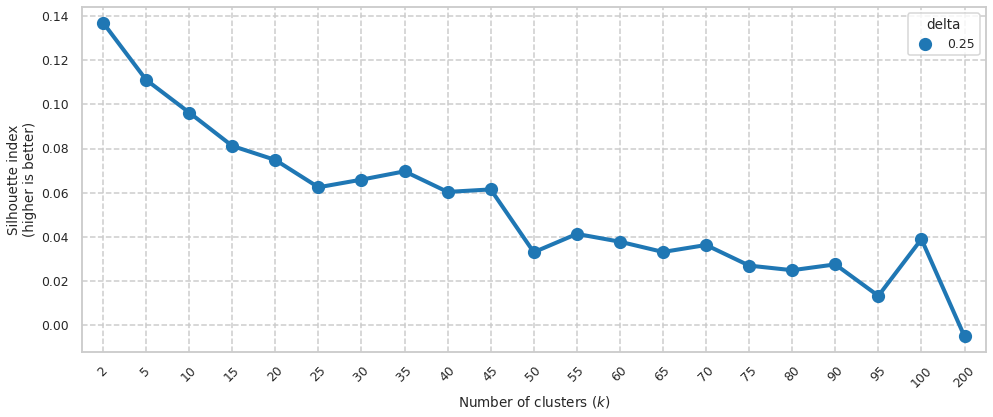

In [41]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score", hue="delta")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()